# A1

In [461]:
# Standard imports
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import integrate

## Some supplied helper functions

In [462]:
def PlotSpikeRaster(st, y_range=[0, 1.]):
    '''
    PlotSpikeRaster(spiketimes, y_range=[0, 1.])

    Plots a spike raster plot for a list of arrays of spike times.

    Input:
      spiketimes is a list of arrays of spike times, like that returned
          by the function Stim2Spikes.
      y_range is a 2-tuple that holds the y-values that the raster ticks
          should be drawn between
    '''
    N = len(st)  # number of neurons

    #levels = np.linspace(y_range[0], y_range[1], N+1, endpoint=True)
    levels = np.linspace(y_range[1], y_range[0], N+1, endpoint=True)
    for n in range(N):
        nspikes = len(st[n])
        #y = [ [levels[n]]*nspikes , [levels[n+1]]*nspikes ]
        y = [ [levels[n+1]]*nspikes , [levels[n]]*nspikes ]
        #y = y_range[0] + [levels[n]]*nspikes
        plt.plot(np.vstack((st[n],st[n])), y, color=np.random.rand(3))
    plt.ylim(y_range)
    plt.xlabel('Time (s)')
    return


def GenerateSpikeTrain(rates, T, jitter=0.):
    '''
    spike_times = GenerateSpikeTrain(rates, T)
    
    Creates a spike train (as an array of time stamps).
    
    Input:
    rates is an array or list of firing rates (in Hz), one
        firing rate for each interval.
    T is an array or list (the same size as 'rates') that gives
        the time to end each interval
    jitter is a scalar that determines how much the spikes
        are randomly moved
        
    Output:
    spike_times is an array of times when spikes occurred
    
    Example: To create a spike train of 10Hz for 0.5s, followed
             by 25Hz that starts at 0.5s and ends at 2s, use
             
               GenerateSpikeTrain([10, 25], [0.5, 2])
    '''
    s = []
    t = 0.
    for idx in range(0,len(rates)):
        Trange = T[idx] - t
        if rates[idx]!=0:
            delta = 1. / rates[idx]
            N = rates[idx] * Trange
            times = np.arange(t+delta/2., T[idx], delta)
            times += np.random.normal(scale=delta*jitter, size=np.shape(times))
            s.extend(times)
        t = T[idx]
    s.sort()
    return np.array(s)


class InputNeuron(object):
    
    def __init__(self, spiketrain):
        '''
        InputNeuron(spiketrain)
        
        Constructor for InputNeuron class.
        
        InputNeuron is a class of neuron that can be used to inject spikes into
        the network. When involved in a simulation, an InputNeuron will generate
        spikes at the times specified during its construction.
        
        Inputs:
         spiketrain is an array or list of spike times
        '''
        self.spikes = np.array(spiketrain)

    def SpikesBetween(self, t_start, t_end):
        '''
        numspikes = InputNeuron.SpikesBetween(t_start, t_end)
        
        Returns the number of times the neuron spiked between t_start and t_end.
        Specifically, it counts a spike if it occurred at t, where
        t_start <= t < t_end
        '''
        sp_bool = np.logical_and( np.array(self.spikes)>=t_start, np.array(self.spikes)<t_end )
        return np.sum(sp_bool)
    
    def Slope(self):
        return
    
    def Step(self, t, dt):
        return

# Q1: LIFNeuron Class

## LIFNeuron class

In [463]:
class LIFNeuron(object):

    def __init__(self, tau_m=0.02, tau_ref=0.002, tau_s=0.05):
        '''
        LIFNeuron(tau_m=0.02, tau_ref=0.002, tau_s=0.05)
        
        Constructor for LIFNeuron class
        
        Inputs:
         tau_m   membrane time constant, in seconds (s)
         tau_ref refractory period (s)
         tau_s   synaptic time constant (s)
        '''
        self.tau_m = tau_m      # membrane time constant
        self.tau_ref = tau_ref  # refractory period
        self.tau_s = tau_s      # synaptic time constant
        self.v = 0.             # sub-threshold membrane potential (voltage)
        self.s = 0.             # post-synaptic current (PSC)
        self.dvdt = 0.          # slope of v (w.r.t. time)
        self.dsdt = 0.          # slope of s (w.r.t. time)
        
        self.weighted_incoming_spikes = 0.  # weighted sum of incoming spikes (for one time step)
        self.ref_remaining = 0. # amount of time remaining in the refractory period
        
        # For plotting
        self.v_history = []     # records v over time
        self.spikes = []        # list of times when this neuron spiked
        self.s_history = []     # record postSynatic current over time

    def SpikesBetween(self, t_start, t_end):
        '''
        numspikes = LIFNeuron.SpikesBetween(t_start, t_end)
        
        Returns the number of times the neuron spiked between t_start and t_end.
        Specifically, it counts a spike if it occurred at t, where
        t_start <= t < t_end
        '''
        sp_bool = np.logical_and( np.array(self.spikes)>=t_start, np.array(self.spikes)<t_end )
        return np.sum(sp_bool)
    
    
    def Slope(self):
        '''
        LIFNeuron.Slope()
        
        Evaluates the right-hand side of the differential equations that
        govern v and s. The slopes get stored in the internal variables
          self.dvdt, and
          self.dsdt
        '''
        #==== REPLACE THE CODE BELOW ====
        self.dvdt = (self.s - self.v) / self.tau_m # record the rate of change of sub-threshold membrane potential
                                                   # between spikes
        self.dsdt = -(self.s / self.tau_s)
        
        
    def Step(self, t, dt):
        '''
        LIFNeuron.Step(t, dt)
        
        Updates the LIF neuron state by taking an Euler step in v and s.
        If v reaches the threshold of 1, the neuron fires an action potential
        (spike). The spike time is appended to the list self.spikes, and v
        is set to zero. After a spike, the neuron is dormant for self.tau_ref
        seconds.
        
        If a spike occurs part-way through a time step, inear interpolation
        is used to estimate the time that v hit the threshold of 1.
        '''
        
        #==== PLACE YOUR CODE HERE ====
        
        # Euler's formula section
        # update current postSynatic current
        self.s += dt*self.dsdt + self.weighted_incoming_spikes / self.tau_s 
        # if we are in refactory period, set v to zero and update ref_remaining
        if self.ref_remaining > 0:
            self.v = 0
            self.ref_remaining -= dt
        else:
            self.v += dt * self.dvdt
        # spike happens
        if self.v >= 1.0:
            # update spike time 
            prevVoltage = self.v_history[-1]
            currVoltage = self.v
            timeSpike = t + dt * ((1 - prevVoltage)/(currVoltage - prevVoltage))
            self.spikes.append(timeSpike)
            # set v to the threshold
            self.v = 1
            # update self.ref_remaining, t is the current time
            timePassedAfterSpike = timeSpike - t
            self.ref_remaining = self.tau_ref - timePassedAfterSpike
        # Store v (for plotting), and reset incoming spike accumulator
        self.s_history.append(self.s)
        self.v_history.append(self.v)
        self.weighted_incoming_spikes = 0
        
    def ReceiveSpike(self, w):
        '''
        LIFNeuron.ReceiveSpike(w)
        
        Registers the arrival of a spike from a presynaptic neuron. The
        member variable self.weighted_incoming_spikes keeps track of all
        the incoming spikes, each weighted by their respective connection
        weights. It is sufficient to add them all together to tabulate the
        total incoming weighted spikes (from all presynaptic neurons).
        
        Input:
         w    is the connection weight from the presynaptic neuron.
        '''
        self.weighted_incoming_spikes += w  # [1]
        

# Q2: SpikingNetwork Class

## SpikingNetwork Class

In [464]:
class SpikingNetwork(object):
    
    def __init__(self):
        '''
        SpikingNetwork()
        
        Constructor for SpikingNetwork class.
        
        The SpikingNetwork class contains a collection of neurons,
        and the connections between those neurons.
        '''
        self.neurons = []      # List of neurons (of various kinds)
        self.connections = []  # List of connections
        self.t_history = []    # List of time stamps for the Euler steps
                               # (Useful for plotting)
        
        
    def AddNeuron(self, neur):
        '''
        SpikingNetwork.AddNeuron(neuron)
        
        Adds a neuron to the network.
        
        Input:
         neuron is an object of type LIFNeuron or InputNeuron
        '''
        self.neurons.append(neur)

        
    def Connect(self, pre, post, w):
        '''
        SpikingNetwork.Connect(pre, post, w)
        
        Connects neuron 'pre' to neuron 'post' with a connection
        weigth of w.
        
        Each "connection" is a list of 3 numbers of the form:
         [ pre_idx, post_idx, weight ]
        where
         pre_idx is the list index of the pre-synaptic neuron,
         post_idx is the list index of the post-synaptic neuron, and
         weight is the connection weight.
        eg. self.connections = [[0,1,0.05], [1,2,0.04], [1,0,-0.2]]
        '''
        self.connections.append([pre, post, w])
     
    
    def Simulate(self, T, dt=0.001):
        '''
        SpikingNetwork.Simulate(T, dt=0.001)
        
        Simulates the network for T seconds by taking Euler steps
        of size dt.
        
        Inputs:
         T    how long to integrate for
         dt   time step for Euler's method
        '''
        # This code takes care of recording time samples in a way
        # that allows continuation. You needn't fuss over this code.
        current = 0 if len(self.t_history)==0 else self.t_history[-1]
        t_segment = np.arange(current, current+T, dt)
        
        #==== HERE IS WHERE YOUR CODE STARTS ====
        
        # Loop over time steps (I've set that up for you)
        # tt is the time step
        for tt in t_segment:
            self.t_history.append(tt)  # Record time stamp for each Euluer method
            # update neuron's slope
            for neuron in self.neurons:
                neuron.Slope()
            # update neuron's step
            for neuron in self.neurons:
                neuron.Step(tt, dt)
            # tabulate the next step
            for previousSynaticNeuron, postSynaticNeuron, weight in self.connections:
                timeStampAfterSpike = tt + dt
                numberOfSpikes=self.neurons[previousSynaticNeuron].SpikesBetween(tt, tt+dt)
                self.neurons[postSynaticNeuron].ReceiveSpike(numberOfSpikes*weight)
            
        #==== PLACE YOUR CODE HERE ====

        
        
    def AllSpikeTimes(self):
        '''
        SpikingNetwork.AllSpikeTimes()
        
        Returns all the spikes of all the neurons in the network.
        Useful for making spike-raster plots of network activity.
        
        Output:
         all_spikes  a list of sublists, where each sublist holds
                     the spike times of one of the neurons
        '''
        blah = []
        for neur in self.neurons:
            blah.append(np.array(neur.spikes))
        return blah

# Q3: Experiments with Spiking Networks

## (a) One LIF Neuron

In [465]:
net = SpikingNetwork()
'''
         tau_m   membrane time constant, in seconds (s)
         tau_ref refractory period (s)
         tau_s   synaptic time constant (s)
'''
net.AddNeuron(LIFNeuron(tau_m=0.02,tau_ref=0.002, tau_s=0.1))  # Neuron 0
# GenerateSpikeTrain(rates, T)
# rate is an array or list of firing rates (in Hz), one firing rate for each interval.
# T is an array or list( the same size as "rates") that gives the time to end eac iterval

# InputNeuron is not a real neuron; Its only job is to deliver spikes, which is useful to activate
# the other(real) neurons in the network
net.AddNeuron(InputNeuron( GenerateSpikeTrain([30], [1]) ))  # Neuron 1
# Connects neuron 'pre' to neuron 'post' with a connection weigtht of w.
net.Connect(1, 0, 0.05)  # Connect from neuron 1 to neuron 0

# Simulates the network for T seconds by taking Euler steps of size dt.
net.Simulate(1, 0.001)

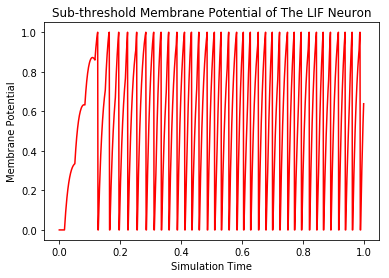

In [466]:
# i.
neuron0=net.neurons[0]
simulationTime=net.t_history
subThreadholdMembranePotentialOfNeuron0=neuron0.v_history

# create figure (empyt canvas) by default
plt.figure()
plt.plot(simulationTime, subThreadholdMembranePotentialOfNeuron0, 'r')
plt.xlabel('Simulation Time')
plt.ylabel('Membrane Potential')
plt.title('Sub-threshold Membrane Potential of The LIF Neuron')
plt.show()

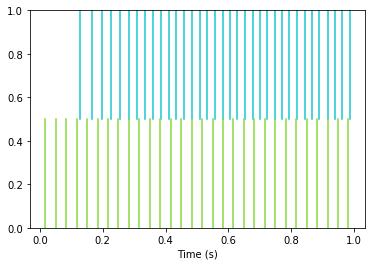

In [467]:
# ii.
spikesTimeOfAllNeuronsInNetwork=net.AllSpikeTimes()
PlotSpikeRaster(spikesTimeOfAllNeuronsInNetwork)

## (b) LIF Firing Rate Curve

In [468]:
# creat a list of firing rate(rates) and a list of time interval(T) for function GenerateSpikeTrain
listOfFiringRates=[]
listOfTimeIntervals=[]
startingFiringRate=0
startingFiringTime=0
for i in range(20):
    startingFiringRate += 5
    startingFiringTime +=2
    listOfFiringRates.append(startingFiringRate)
    listOfTimeIntervals.append(startingFiringTime)
print("firing rate is:")
print(listOfFiringRates)
print("listOfTimeIntervals is:")
print(listOfTimeIntervals)

firing rate is:
[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
listOfTimeIntervals is:
[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40]


In [469]:
# i
# network from 3b
net = SpikingNetwork()
'''
         tau_m   membrane time constant, in seconds (s)
         tau_ref refractory period (s)
         tau_s   synaptic time constant (s)
'''
net.AddNeuron(LIFNeuron(tau_m=0.02,tau_ref=0.002, tau_s=0.1))  # Neuron 0
# GenerateSpikeTrain(rates, T)
# rate is an array or list of firing rates (in Hz), one firing rate for each interval.
# T is an array or list( the same size as "rates") that gives the time to end each iterval

# InputNeuron is not a real neuron; Its only job is to deliver spikes, which is useful to activate
# the other(real) neurons in the network
net.AddNeuron(InputNeuron(GenerateSpikeTrain(listOfFiringRates, listOfTimeIntervals)))  # Neuron 1
# Connects neuron 'pre' to neuron 'post' with a connection weigtht of w.
net.Connect(1, 0, 0.03)  # Connect from neuron 1 to neuron 0

# Simulates the network for T seconds by taking Euler time steps of size dt.
net.Simulate(40, 0.001)

In [470]:
# ii.
num2sIntervals=20
startingTime=0
#######this part will be used in iii###########
numLIFSpikesList=[]
numInputSpikesList=[]
###############################################
for i in range(num2sIntervals):
    endOfTimeInterval = startingTime + 2
    print('startTime: %d, endTime: %d' % (startingTime,endOfTimeInterval))
    # index 0 is the LIFNeuron, index 1 is the InputNeuron
    ##########will be used in iii#################
    numLIFSpikesList.append(net.neurons[0].SpikesBetween(startingTime,endOfTimeInterval))
    numInputSpikesList.append(net.neurons[1].SpikesBetween(startingTime,endOfTimeInterval))
    ##############################################
    print("numLIFSpikes %d" % net.neurons[0].SpikesBetween(startingTime,endOfTimeInterval))
    print("numInputSpikes %d" % net.neurons[1].SpikesBetween(startingTime,endOfTimeInterval))
    numSpikes=net.neurons[0].SpikesBetween(startingTime,endOfTimeInterval) + net.neurons[1].SpikesBetween(startingTime,endOfTimeInterval)
    print("numSpike %d" % numSpikes)
    startingTime = startingTime + 2

startTime: 0, endTime: 2
numLIFSpikes 0
numInputSpikes 10
numSpike 10
startTime: 2, endTime: 4
numLIFSpikes 0
numInputSpikes 20
numSpike 20
startTime: 4, endTime: 6
numLIFSpikes 0
numInputSpikes 30
numSpike 30
startTime: 6, endTime: 8
numLIFSpikes 0
numInputSpikes 40
numSpike 40
startTime: 8, endTime: 10
numLIFSpikes 0
numInputSpikes 50
numSpike 50
startTime: 10, endTime: 12
numLIFSpikes 0
numInputSpikes 60
numSpike 60
startTime: 12, endTime: 14
numLIFSpikes 30
numInputSpikes 70
numSpike 100
startTime: 14, endTime: 16
numLIFSpikes 52
numInputSpikes 80
numSpike 132
startTime: 16, endTime: 18
numLIFSpikes 72
numInputSpikes 90
numSpike 162
startTime: 18, endTime: 20
numLIFSpikes 85
numInputSpikes 100
numSpike 185
startTime: 20, endTime: 22
numLIFSpikes 96
numInputSpikes 110
numSpike 206
startTime: 22, endTime: 24
numLIFSpikes 109
numInputSpikes 120
numSpike 229
startTime: 24, endTime: 26
numLIFSpikes 122
numInputSpikes 130
numSpike 252
startTime: 26, endTime: 28
numLIFSpikes 133
numInputS

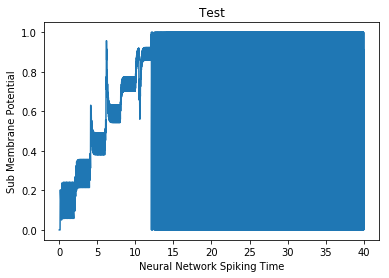

In [471]:
# This cell is for test, see if the firing rate increase
plt.plot(net.t_history, net.neurons[0].v_history)
plt.xlabel('Neural Network Spiking Time')
plt.ylabel('Sub Membrane Potential')
plt.title('Test')
plt.show()

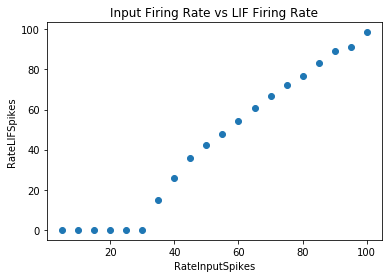

In [472]:
# b iii.
# covert LIF and Input to an array and calculate their rate of firing in a specific interval
numLIFSpikesArray = np.asarray(numLIFSpikesList)
rateLIFSpikesArray = numLIFSpikesArray/2
numInputSpikesArray = np.asarray(numInputSpikesList)
rateInputSpikesArray = numInputSpikesArray/2
plt.scatter(rateInputSpikesArray, rateLIFSpikesArray)
plt.xlabel('RateInputSpikes')
plt.ylabel('RateLIFSpikes')
plt.title('Input Firing Rate vs LIF Firing Rate')
plt.show()

## (c) Two LIF Neurons

In [473]:
# i.
# create a neural network
net = SpikingNetwork()
'''
         tau_m   membrane time constant, in seconds (s)
         tau_ref refractory period (s)
         tau_s   synaptic time constant (s)
'''
# add neuron A to the nural network with index 0
net.AddNeuron(LIFNeuron(tau_m=0.02,tau_ref=0.002, tau_s=0.05))  # Neuron 0
# add neuron B to the nural network with index 1
net.AddNeuron(LIFNeuron(tau_m=0.02,tau_ref=0.002, tau_s=0.05))  # Neuron 1
# add input neuron to the nural network with index 2            # Neuron 2
net.AddNeuron(InputNeuron(GenerateSpikeTrain([30], [0.3])))

# connect Neuron from 0 to 1 with weight 0.05
net.Connect(0, 1, 0.05)  # Connect from neuron 0 to neuron 1
# connect Neuron from 1 to 0 with weight 0.05
net.Connect(1, 0, 0.05)  # Connect from neuron 1 to neuron 0
# connect Neuron from 2 to 0 with weight 0.05
net.Connect(2, 0, 0.05)  # Connect from neuron 2 to neuron 0

# Simulates the network for T seconds(1s) by taking Euler time steps of size dt(0.0001).
net.Simulate(1, 0.001)



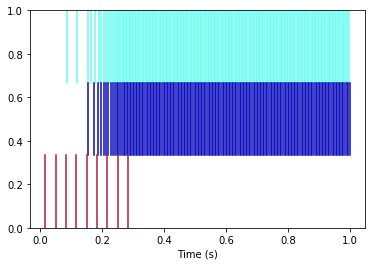

In [474]:
# ii.
# A spike-raster plot for the three neurons in the network
spikesTimeOfAllNeuronsInNetwork=net.AllSpikeTimes()
PlotSpikeRaster(spikesTimeOfAllNeuronsInNetwork)

## (d) Three LIF Neurons: Inhibition

In [475]:
# i.
# create a neural network
net = SpikingNetwork()
'''
         tau_m   membrane time constant, in seconds (s)
         tau_ref refractory period (s)
         tau_s   synaptic time constant (s)
'''
# add neuron A to the nural network with index 0
net.AddNeuron(LIFNeuron(tau_m=0.02,tau_ref=0.002, tau_s=0.05))  # Neuron 0
# add neuron B to the nural network with index 1
net.AddNeuron(LIFNeuron(tau_m=0.02,tau_ref=0.002, tau_s=0.05))  # Neuron 1
# add neuron C to the nural network with index 2
net.AddNeuron(LIFNeuron(tau_m=0.02,tau_ref=0.002, tau_s=0.05))  # Neuron 2
# add neuron inputTop to the nural network with index 3
net.AddNeuron(InputNeuron(GenerateSpikeTrain([30], [0.3])))     # Neuron 3
# add neuron inputBottom to the nural network with index 4 
net.AddNeuron(InputNeuron(GenerateSpikeTrain([0, 50], [0.7, 1.])))     # Neuron 4

# connect Neuron from 0 to 1 with weight 0.05
net.Connect(0, 1, 0.05)  # Connect from neuron 0 to neuron 1
# connect Neuron from 1 to 0 with weight 0.05
net.Connect(1, 0, 0.05)  # Connect from neuron 1 to neuron 0
# connect Neuron from 2 to 1 with weight -0.2
net.Connect(2, 1, -0.2)  # Connect from neuron 2 to neuron 1
# connect Neuron from 3 to 0 with weight 0.05
net.Connect(3, 0, 0.05)  # Connect from neuron 3 to neuron 0
# connect Neuron from 4 to 2 with weight 0.05
net.Connect(4, 2, 0.05)  # Connect from neuron 4 to neuron 2
# Simulates the network for T seconds(1.5s) by taking Euler time steps of size dt(0.0001).
net.Simulate(1.5, 0.001)


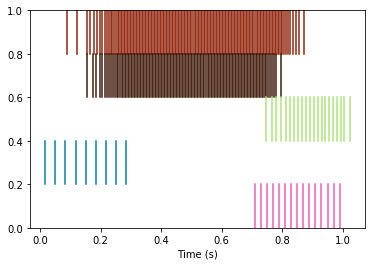

In [476]:
# ii.
# A spike-raster plot for the three neurons in the network
spikesTimeOfAllNeuronsInNetwork=net.AllSpikeTimes()
PlotSpikeRaster(spikesTimeOfAllNeuronsInNetwork)

### iii.

Your answer here.
When neuron A exceeds 0.8s and neuron B exceed 0.75s, they spiked much slower than before. Also, A and B stopped spiking at around 0.85s and 0.8s respectively as compared to both of them were spiking till the end of 1s.
This is because an inputNeuron which connected to LIFC spikes after 0.7s and LIFC has a negative connection weight to LIFB, so LIFC will inhibit the activity of LIFB directly and that's one of the reason B stopped spiking first. Since B was inhibited by LIFC somehow, LIFA also spiked much slower and stopped earlier than before.

## (e) Ring Oscillator

In [477]:
# i.
# create a neural network
net = SpikingNetwork()
'''
         tau_m   membrane time constant, in seconds (s)
         tau_ref refractory period (s)
         tau_s   synaptic time constant (s)
'''
# add neuron from A to H to the network and form a ring
for i in range(8):
    net.AddNeuron(LIFNeuron(tau_m=0.05,tau_s=0.1))
# connect from Neuron A to itself to form a ring
for i in range(8):
    startNeuronIndex=i
    toNeuronIndex=i+1
    # handle the last case toNeuronIndex 8 which should be 0 in this case
    if(toNeuronIndex == 8):
        # connect from neuron 7 to 0
        net.Connect(startNeuronIndex, 0, 0.2)
    else: 
        net.Connect(startNeuronIndex, toNeuronIndex, 0.2)
    

In [478]:
# ii.
# connect from H to itself in a reverse direction and with negative weight -0.4
for i in range(7,-1,-1): # i=7to0
    startNeuronIndex=i
    toNeuronIndex=i-1
    # handle the last case toNeuronIndex -1 which should be 7 in this case
    if (toNeuronIndex == -1):
        # connect from neuron 7 to 0
        net.Connect(startNeuronIndex, 7, -0.4)
    else:
        net.Connect(startNeuronIndex, toNeuronIndex, -0.4)

In [479]:
# iii.
# add an input neuron to the neural network
net.AddNeuron(InputNeuron(GenerateSpikeTrain([25], [0.3]))) # input neuron with index 8
# connect input neuron to neuron A with connection weight 0.2
net.Connect(8, 0, 0.2)

In [480]:
# iv.
# Simulates the network for T seconds(4s) by taking Euler time steps of size dt(0.0001).
net.Simulate(4, 0.001)

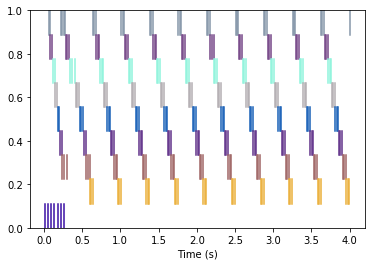

In [481]:
# A spike-raster plot for the three neurons in the network
spikesTimeOfAllNeuronsInNetwork=net.AllSpikeTimes()
PlotSpikeRaster(spikesTimeOfAllNeuronsInNetwork)

# Q4: Neural Activation Functions

## (a) ReLU derivative

ReLU(z) = 1, if z >0 

ReLU(z) = 0, otherwise


## (b.i) Logistic

In [482]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import integrate

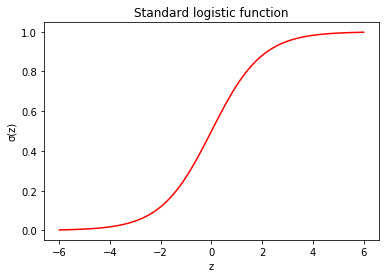

In [483]:
import math
# i.
# σ(z) = 1/(1+e^-z)
# use function to produce x and y points first
z = np.linspace(-6,6,100)
y = 1/(1+(math.e ** (-z)))
dydz = np.gradient(y)

plt.plot(z, y, 'r')
plt.xlabel('z')
plt.ylabel('σ(z)')
plt.title('Standard logistic function')
plt.show()



YOUR ANSWER HERE
1. as the value of z approaches 6 or z approaches -6, the derivative approaches zero
2. when the z is at 0, the gradient is maximized

## (b.ii) tanh

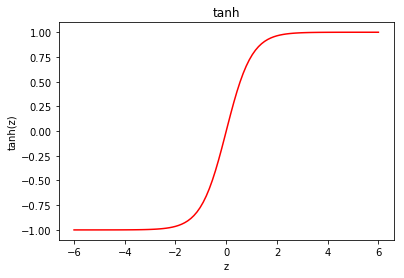

In [484]:
# ii.
z = np.linspace(-6,6,100)
y = (1 - (math.e ** (-2 * z)))/(1 + (math.e ** (-2 * z)))
dydz = np.gradient(y)

plt.plot(z, y, 'r')
plt.xlabel('z')
plt.ylabel('tanh(z)')
plt.title('tanh')
plt.show()

1. as the value of z approaches 6 or z approaches -6, the derivative approaches zero
2. when the z is at 0, the gradient is maximized

## (b.iii) ReLU

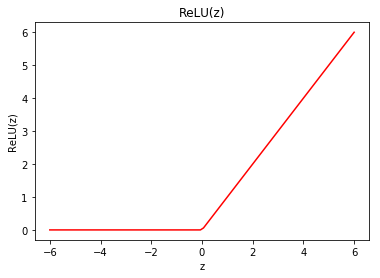

In [485]:
# iii.
z = np.linspace(-6,6,100)
y = []
for x in z:
    if (x >=0):
        y.append(x)
    else:
        y.append(0)
y = np.array(y)
dydz = np.gradient(y)
    # first plot standard logistic function σ(z)
plt.plot(z, y, 'r')
plt.xlabel('z')
plt.ylabel('ReLU(z)')
plt.title('ReLU(z)')
plt.show()

1. When z value is less than 0, the the derivative is euqual to zero
2. when z value is greater than 0, the derivative is maximum

## (c.i) Derivative of f with respect to x

w*f'(wx+b) 

## (c.ii) Derivative of f with respect to W

x*f'(wx+b)

## (c.ii) Derivative of f with respect to b

f'(wx+b)